In [1]:
"""# 🔎 Evaluation & Explainability

This notebook evaluates previously trained flow-level and packet-level models, computes unified metrics and latency summaries, and produces explainability artifacts:

- Flow models: Logistic Regression, Random Forest, IsolationForest
- Packet model: Tiny 1D-CNN (PyTorch → ONNX)
- Explainability: Tree importances, permutation importance, SHAP-lite (tabular), occlusion sensitivity & gradient*input for CNN payload bytes
- Output: `/artifacts/eval/*` PNGs, JSONs, and a per-alert explanation generator for the agent

**Inputs:**
- `artifacts/models/flow_*/*.joblib` (pick latest)
- `artifacts/models/packet_cnn_torch_v1.onnx` (or .pt)
- `data/features/*` (flow & packet features)
- `data/sample/*` (for example traces)
"""

'# 🔎 Evaluation & Explainability\n\nThis notebook evaluates previously trained flow-level and packet-level models, computes unified metrics and latency summaries, and produces explainability artifacts:\n\n- Flow models: Logistic Regression, Random Forest, IsolationForest\n- Packet model: Tiny 1D-CNN (PyTorch → ONNX)\n- Explainability: Tree importances, permutation importance, SHAP-lite (tabular), occlusion sensitivity & gradient*input for CNN payload bytes\n- Output: `/artifacts/eval/*` PNGs, JSONs, and a per-alert explanation generator for the agent\n\n**Inputs:**\n- `artifacts/models/flow_*/*.joblib` (pick latest)\n- `artifacts/models/packet_cnn_torch_v1.onnx` (or .pt)\n- `data/features/*` (flow & packet features)\n- `data/sample/*` (for example traces)\n'

In [2]:
import os, json, time, glob
from pathlib import Path
import numpy as np
import pandas as pd
import random
import joblib
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.inspection import permutation_importance
import shap  # optional; we'll use a small-budget approach
import onnxruntime as ort
import torch

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ensure eval artifacts dir
Path("artifacts/eval").mkdir(parents=True, exist_ok=True)
print("SEED:", SEED)


d:\project\Network Traffic Analysis and Packet Inspection using ML and Agentic AI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SEED: 42


In [6]:
"""## Load flow-level features and labels
We read `data/features/flow_features.pkl` produced earlier. If multiple versions exist, we pick the most recent.
"""

'## Load flow-level features and labels\nWe read `data/features/flow_features.pkl` produced earlier. If multiple versions exist, we pick the most recent.\n'

In [7]:
flow_feat_path = "data/features/flow_features.pkl"
if not os.path.exists(flow_feat_path):
    raise FileNotFoundError(flow_feat_path + " not found. Run 02_preprocessing_and_feature_engineering.ipynb")

flow_pack = joblib.load(flow_feat_path)
X = flow_pack["features"]
y = flow_pack["labels"]
print("Flow features shape:", X.shape, "Labels present:", y is not None)


Flow features shape: (50, 10) Labels present: True


In [8]:
"""## Load latest flow-level model artifacts
We search `artifacts/models/` for the most recent joblib model files for logreg and rf and iforest.
"""

'## Load latest flow-level model artifacts\nWe search `artifacts/models/` for the most recent joblib model files for logreg and rf and iforest.\n'

In [9]:
model_dir = Path("artifacts/models")
logreg_path = sorted(glob.glob(str(model_dir / "flow_logreg_*.joblib")))[-1]
rf_path = sorted(glob.glob(str(model_dir / "flow_rf_*.joblib")))[-1]
if_path = sorted(glob.glob(str(model_dir / "flow_iforest_*.joblib")))[-1]

print("Loading models:")
print(" -", logreg_path)
print(" -", rf_path)
print(" -", if_path)

logreg = joblib.load(logreg_path)
rf = joblib.load(rf_path)
iforest = joblib.load(if_path)


Loading models:
 - artifacts\models\flow_logreg_20251108_231711.joblib
 - artifacts\models\flow_rf_20251108_231711.joblib
 - artifacts\models\flow_iforest_20251108_231711.joblib


In [10]:
"""To ensure consistent evaluation with earlier notebooks, we use a deterministic split. If you used stratified split earlier, reuse the same indices; otherwise create a simple deterministic split using SEED.
"""

'To ensure consistent evaluation with earlier notebooks, we use a deterministic split. If you used stratified split earlier, reuse the same indices; otherwise create a simple deterministic split using SEED.\n'

In [11]:
from sklearn.model_selection import train_test_split
# deterministic stratified split if classes exist
if y is None:
    raise ValueError("No labels for flow-level data. Cannot compute supervised metrics.")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print("Train/Test sizes:", X_train.shape, X_test.shape)


Train/Test sizes: (40, 10) (10, 10)


In [12]:
"""Compute precision, recall, F1, ROC-AUC, confusion matrices for Logistic Regression and Random Forest.
"""

'Compute precision, recall, F1, ROC-AUC, confusion matrices for Logistic Regression and Random Forest.\n'

In [13]:
def eval_and_report(model, X_test, y_test, model_name, prob_fn=True):
    y_pred = model.predict(X_test)
    res = {
        "precision": float(precision_score(y_test, y_pred, zero_division=0)),
        "recall": float(recall_score(y_test, y_pred, zero_division=0)),
        "f1": float(f1_score(y_test, y_pred, zero_division=0)),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist(),
    }
    if prob_fn and hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
        try:
            res["roc_auc"] = float(roc_auc_score(y_test, y_prob))
        except Exception:
            res["roc_auc"] = None
    print(f"\n=== {model_name} ===")
    print(pd.Series(res).to_string())
    return res

lr_metrics = eval_and_report(logreg, X_test, y_test, "LogisticRegression")
rf_metrics = eval_and_report(rf, X_test, y_test, "RandomForest")



=== LogisticRegression ===
precision                        1.0
recall                           1.0
f1                               1.0
confusion_matrix    [[2, 0], [0, 8]]
roc_auc                          1.0

=== RandomForest ===
precision                        1.0
recall                           1.0
f1                               1.0
confusion_matrix    [[2, 0], [0, 8]]
roc_auc                          1.0


In [14]:
"""We map iforest outputs (-1 anomaly, 1 normal) to labels compatible with supervised metrics.
"""

'We map iforest outputs (-1 anomaly, 1 normal) to labels compatible with supervised metrics.\n'

In [15]:
if_pred = iforest.predict(X_test)  # -1 anomaly, 1 normal
# convert to attack=1: -1 -> 1 else 0
if_pred_bin = np.where(if_pred == -1, 1, 0)
if_metrics = {
    "precision": float(precision_score(y_test, if_pred_bin, zero_division=0)),
    "recall": float(recall_score(y_test, if_pred_bin, zero_division=0)),
    "f1": float(f1_score(y_test, if_pred_bin, zero_division=0)),
    "confusion_matrix": confusion_matrix(y_test, if_pred_bin).tolist()
}
print("\n=== IsolationForest ===")
print(if_metrics)



=== IsolationForest ===
{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'confusion_matrix': [[2, 0], [8, 0]]}


In [16]:
flow_eval = {
    "timestamp": datetime.now().isoformat(),
    "seed": SEED,
    "lr": lr_metrics,
    "rf": rf_metrics,
    "iforest": if_metrics
}
with open("artifacts/eval/flow_models_eval.json", "w") as f:
    json.dump(flow_eval, f, indent=2)
print("Saved → artifacts/eval/flow_models_eval.json")


Saved → artifacts/eval/flow_models_eval.json


In [17]:
"""We visualize:
1. RandomForest built-in `feature_importances_`.
2. Permutation importance (small budget) to get a more robust importance estimate (costly; keep `n_repeats=10`).
"""

'We visualize:\n1. RandomForest built-in `feature_importances_`.\n2. Permutation importance (small budget) to get a more robust importance estimate (costly; keep `n_repeats=10`).\n'

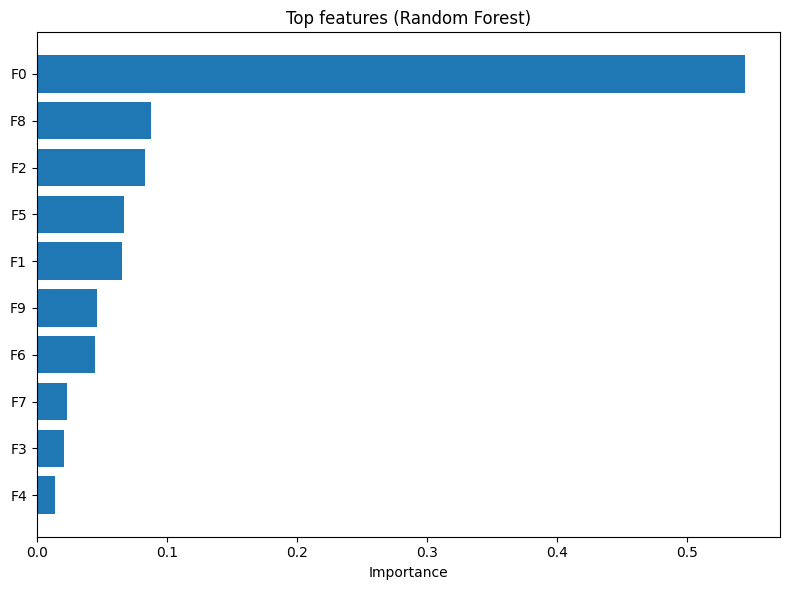

Saved → artifacts/eval/rf_feature_importance.png


In [18]:
import matplotlib.pyplot as plt
import numpy as np

feat_imp = rf.feature_importances_
top_idx = np.argsort(feat_imp)[-20:]
plt.figure(figsize=(8,6))
plt.barh(range(len(top_idx)), feat_imp[top_idx])
plt.yticks(range(len(top_idx)), [f"F{idx}" for idx in top_idx])
plt.xlabel("Importance")
plt.title("Top features (Random Forest)")
plt.tight_layout()
plt.savefig("artifacts/eval/rf_feature_importance.png", dpi=150)
plt.show()
print("Saved → artifacts/eval/rf_feature_importance.png")


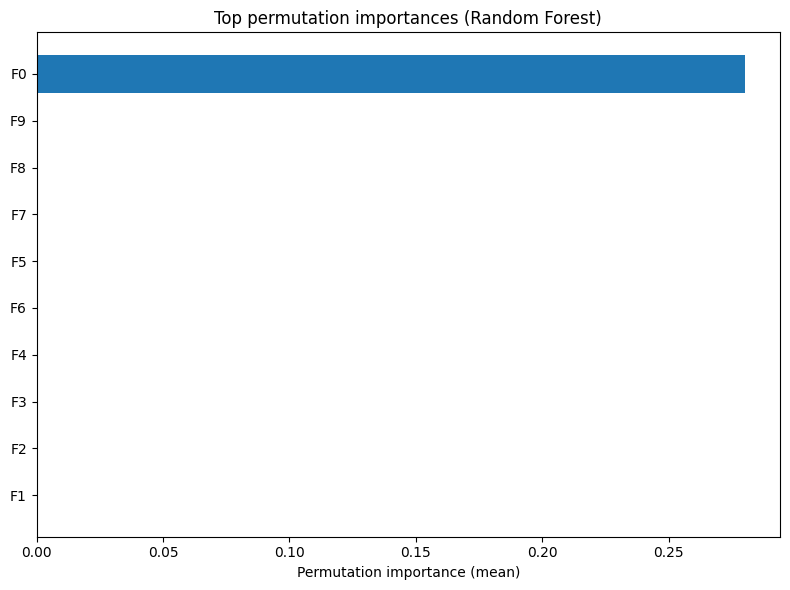

Saved permutation importance artifacts.


In [19]:
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=SEED, n_jobs=1)
perm_idx = np.argsort(perm.importances_mean)[-20:]
plt.figure(figsize=(8,6))
plt.barh(range(len(perm_idx)), perm.importances_mean[perm_idx])
plt.yticks(range(len(perm_idx)), [f"F{idx}" for idx in perm_idx])
plt.xlabel("Permutation importance (mean)")
plt.title("Top permutation importances (Random Forest)")
plt.tight_layout()
plt.savefig("artifacts/eval/rf_permutation_importance.png", dpi=150)
plt.show()
with open("artifacts/eval/rf_permutation_importance.json", "w") as f:
    json.dump({
        "importances_mean": perm.importances_mean.tolist(),
        "importances_std": perm.importances_std.tolist()
    }, f, indent=2)
print("Saved permutation importance artifacts.")


In [20]:
"""Full SHAP can be slow. We implement a **SHAP-lite** local explanation: for a given instance, we (a) sample a small background set (k=50), (b) perturb each feature by replacing it with background values and measure change in model output probability — computing a local feature contribution estimate. This is cheap and deterministic with fixed seed.
"""

'Full SHAP can be slow. We implement a **SHAP-lite** local explanation: for a given instance, we (a) sample a small background set (k=50), (b) perturb each feature by replacing it with background values and measure change in model output probability — computing a local feature contribution estimate. This is cheap and deterministic with fixed seed.\n'

In [21]:
def shap_lite_local(model, X_train_sample, instance, n_samples=50, random_state=SEED):
    """
    model: classifier with predict_proba
    X_train_sample: background matrix (k, d)
    instance: (d,) array
    returns dict {feature_idx: contribution}
    """
    np.random.seed(random_state)
    base_probs = model.predict_proba(X_train_sample).mean(axis=0)[1]  # average base prob
    d = instance.shape[0]
    contributions = np.zeros(d)
    for feat in range(d):
        diffs = []
        for b in range(X_train_sample.shape[0]):
            perturbed = instance.copy()
            perturbed[feat] = X_train_sample[b, feat]
            prob = model.predict_proba(perturbed.reshape(1, -1))[0,1]
            diffs.append(prob - base_probs)
        contributions[feat] = np.mean(diffs)
    return contributions

# Example: pick one test instance and compute contributions for RF
bg_idx = np.random.choice(X_train.shape[0], min(50, X_train.shape[0]), replace=False)
background = X_train[bg_idx]
inst = X_test[0]
contribs = shap_lite_local(rf, background, inst, n_samples=50)
top_feats = np.argsort(np.abs(contribs))[-10:]
print("Top local features:", top_feats)
# Save local explain for the instance
local_expl = {"instance_idx": 0, "contribs": contribs.tolist(), "top_feats": top_feats.tolist()}
with open("artifacts/eval/rf_shap_lite_example.json", "w") as f:
    json.dump(local_expl, f, indent=2)
print("Saved SHAP-lite example → artifacts/eval/rf_shap_lite_example.json")


Top local features: [0 2 1 7 3 8 4 9 6 5]
Saved SHAP-lite example → artifacts/eval/rf_shap_lite_example.json


In [22]:
"""For the tiny 1D-CNN, we provide two explainability techniques (CPU-safe):
1. **Occlusion sensitivity (sliding window):** mask small windows of bytes (e.g., size=8) and measure drop in attack probability → yields a saliency map over byte positions.
2. **Gradient × Input (simple saliency):** use PyTorch autograd on the logits w.r.t. input to compute gradient * input as an importance proxy (works on PyTorch model).
Both are relatively cheap for single examples; we save per-alert visualizations to `/artifacts/eval/packet_*`.
"""

'For the tiny 1D-CNN, we provide two explainability techniques (CPU-safe):\n1. **Occlusion sensitivity (sliding window):** mask small windows of bytes (e.g., size=8) and measure drop in attack probability → yields a saliency map over byte positions.\n2. **Gradient × Input (simple saliency):** use PyTorch autograd on the logits w.r.t. input to compute gradient * input as an importance proxy (works on PyTorch model).\nBoth are relatively cheap for single examples; we save per-alert visualizations to `/artifacts/eval/packet_*`.\n'

In [23]:
ONNX_PATH = "artifacts/models/packet_cnn_torch_v1.onnx"
if not os.path.exists(ONNX_PATH):
    raise FileNotFoundError("ONNX packet model not found. Run 04 packet notebook first.")

ort_sess = ort.InferenceSession(ONNX_PATH, providers=["CPUExecutionProvider"])
input_name = ort_sess.get_inputs()[0].name

def onnx_predict_prob(batch_np):
    # batch_np shape: (batch,1,128) dtype float32
    outputs = ort_sess.run(None, {input_name: batch_np.astype(np.float32)})
    probs = torch.softmax(torch.tensor(outputs[0]), dim=1)[:,1].numpy()
    return probs


In [24]:
# Load packet payloads
payloads = np.load("data/features/packet_features.npy")  # (N,128) uint8
payloads_norm = payloads.astype(np.float32) / 255.0

# pick up to 3 examples: one true positive, one false positive, one false negative if available
# We'll use packet-level labels derived earlier heuristic if available (try loading)
try:
    with open("artifacts/eval/packet_model_eval.json", "r") as f:
        pkt_eval = json.load(f)
except:
    pkt_eval = None

# We'll just select 3 random indices from test indices if available
from torch.utils.data import Subset
# try to reuse test indices from previous notebook by loading them if saved; fallback to deterministic selection
test_idx_path = "artifacts/eval/packet_test_indices.json"
if os.path.exists(test_idx_path):
    with open(test_idx_path) as f:
        test_idx = json.load(f)["test_idx"]
else:
    total = payloads_norm.shape[0]
    test_idx = list(range(int(total*0.8), total))[:100]  # small test pool

example_indices = test_idx[:3]
examples = payloads_norm[example_indices]  # shape (k,128)
print("Selected example packet indices:", example_indices)


Selected example packet indices: [800, 801, 802]


In [25]:
def occlusion_sensitivity(example, window_size=8, stride=4):
    """
    example: (128,) float32 array normalized
    returns: saliency array of length 128 (importance score)
    """
    L = len(example)
    baseline = example.copy().reshape(1,1,L).astype(np.float32)
    base_prob = onnx_predict_prob(baseline)[0]
    saliency = np.zeros(L, dtype=np.float32)
    counts = np.zeros(L, dtype=np.int32)
    for start in range(0, L, stride):
        end = min(start+window_size, L)
        perturbed = example.copy()
        perturbed[start:end] = 0.0  # mask
        p = onnx_predict_prob(perturbed.reshape(1,1,L).astype(np.float32))[0]
        # importance: drop in prob (positive means masked region reduced prob)
        saliency[start:end] += (base_prob - p)
        counts[start:end] += 1
    # average overlapping windows
    counts[counts==0] = 1
    saliency = saliency / counts
    return saliency, base_prob


In [28]:
# --- FIXED VERSION: safe standalone cell ---

import torch
import torch.nn as nn  # ✅ Added missing import
import torch.nn.functional as F
import numpy as np
import os

# Path to trained model
PT_PATH = "artifacts/models/packet_cnn_torch_v1.pt"

if not os.path.exists(PT_PATH):
    print("⚠️ Warning: PyTorch model not found; skipping gradient-based saliency.")
    grad_supported = False
else:
    # ✅ Recreate model exactly as defined in 04_packet_level_model_training.ipynb
    class Tiny1DCNN(nn.Module):
        def __init__(self, in_channels=1, n_classes=2):
            super().__init__()
            self.net = nn.Sequential(
                nn.Conv1d(in_channels, 8, kernel_size=5, padding=2),
                nn.ReLU(),
                nn.MaxPool1d(2),
                nn.Conv1d(8, 16, kernel_size=5, padding=2),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                nn.Linear(16, 32),
                nn.ReLU(),
                nn.Linear(32, n_classes)
            )

        def forward(self, x):
            return self.net(x)

    # Load trained weights
    torch_model = Tiny1DCNN().to("cpu")
    torch_model.load_state_dict(torch.load(PT_PATH, map_location="cpu"))
    torch_model.eval()
    grad_supported = True
    print("✅ Loaded Tiny1DCNN for gradient-based saliency.")

def grad_x_input_saliency(example):
    """
    Compute Gradient × Input saliency for a single normalized packet (128 bytes).
    Returns: np.ndarray of shape (128,)
    """
    if not grad_supported:
        print("Gradient saliency not supported — model missing.")
        return None
    inp = torch.tensor(example, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,128)
    inp.requires_grad_()
    logits = torch_model(inp)
    score = logits[0, 1]  # class 1 = "attack"
    score.backward()
    grad = inp.grad.detach().numpy().squeeze()  # (128,)
    saliency = np.abs(grad * inp.detach().numpy().squeeze())
    return saliency



✅ Loaded Tiny1DCNN for gradient-based saliency.


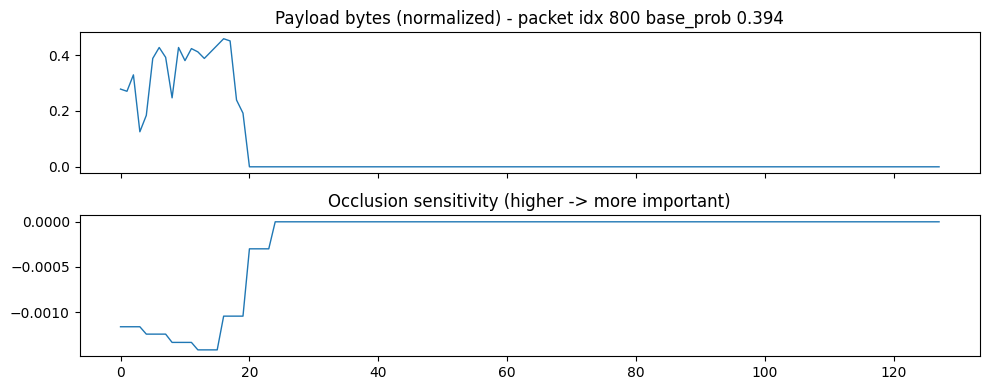

Saved: artifacts/eval/packet_occlusion_800.png


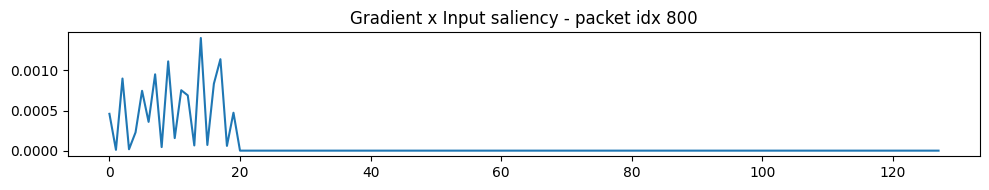

Saved: artifacts/eval/packet_gradxinput_800.png
Saved explanation JSON → artifacts/eval/packet_explain_800.json


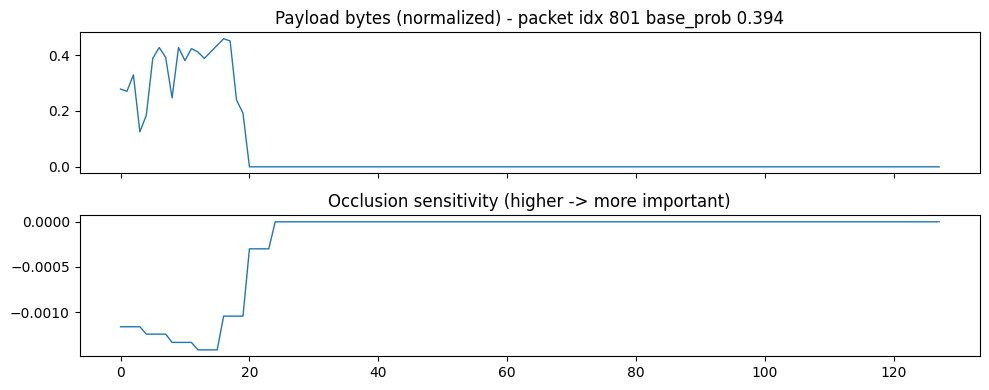

Saved: artifacts/eval/packet_occlusion_801.png


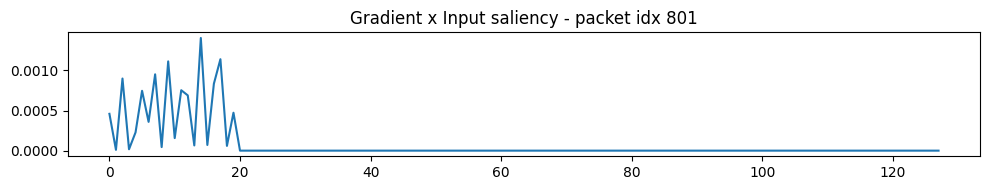

Saved: artifacts/eval/packet_gradxinput_801.png
Saved explanation JSON → artifacts/eval/packet_explain_801.json


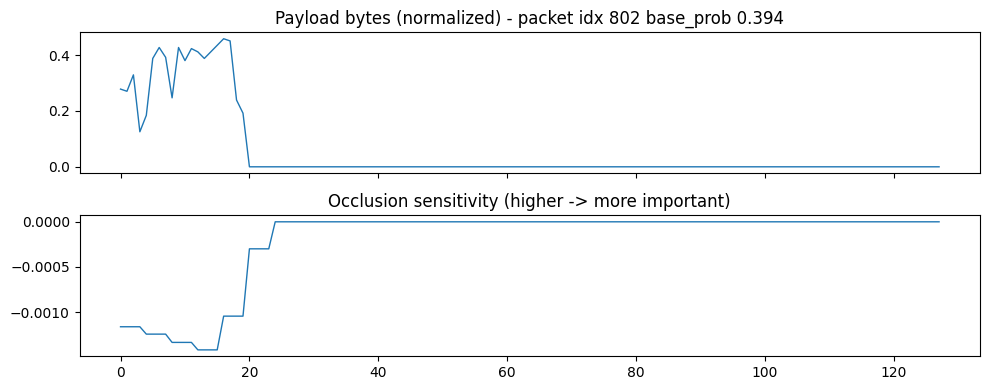

Saved: artifacts/eval/packet_occlusion_802.png


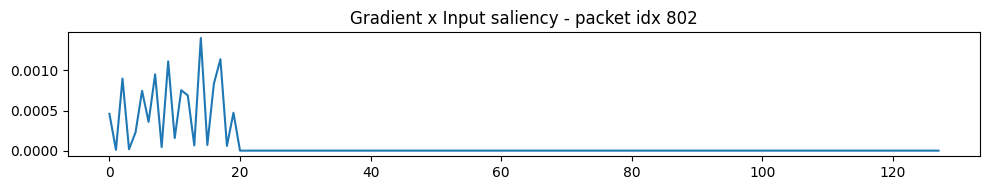

Saved: artifacts/eval/packet_gradxinput_802.png
Saved explanation JSON → artifacts/eval/packet_explain_802.json


In [29]:
for i, idx in enumerate(example_indices):
    ex = examples[i]
    sal_occl, base_prob = occlusion_sensitivity(ex, window_size=8, stride=4)
    fig, ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
    ax[0].plot(ex, linewidth=1)
    ax[0].set_title(f"Payload bytes (normalized) - packet idx {idx} base_prob {base_prob:.3f}")
    ax[1].plot(sal_occl, linewidth=1)
    ax[1].set_title("Occlusion sensitivity (higher -> more important)")
    plt.tight_layout()
    out_png = f"artifacts/eval/packet_occlusion_{idx}.png"
    plt.savefig(out_png, dpi=150)
    plt.show()
    print("Saved:", out_png)

    # gradient x input saliency if supported
    if grad_supported:
        sal_grad = grad_x_input_saliency(ex)
        plt.figure(figsize=(10,2))
        plt.plot(sal_grad)
        plt.title(f"Gradient x Input saliency - packet idx {idx}")
        plt.tight_layout()
        out_png2 = f"artifacts/eval/packet_gradxinput_{idx}.png"
        plt.savefig(out_png2, dpi=150)
        plt.show()
        print("Saved:", out_png2)

    # Save numeric saliency arrays for agent consumption
    np.save(f"artifacts/eval/packet_saliency_occlusion_{idx}.npy", sal_occl)
    if grad_supported:
        np.save(f"artifacts/eval/packet_saliency_gradx_{idx}.npy", sal_grad)
    # Create a small JSON report for this example
    report = {
        "packet_idx": int(idx),
        "base_prob": float(base_prob),
        "occlusion_saliency_mean": float(np.mean(sal_occl)),
        "occlusion_saliency_max": float(np.max(sal_occl)),
        "saved_plots": {
            "occlusion": out_png,
            "gradx": out_png2 if grad_supported else None
        }
    }
    with open(f"artifacts/eval/packet_explain_{idx}.json", "w") as f:
        json.dump(report, f, indent=2)
    print("Saved explanation JSON →", f"artifacts/eval/packet_explain_{idx}.json")


In [30]:
"""We assemble explanation snippets combining:
- flow-level SHAP-lite contributions (top 5 features)
- packet-level occlusion saliency peaks (top byte ranges)
- model confidence scores

This JSON summary is suitable for the deterministic agent to log and use to decide transitions.
"""

'We assemble explanation snippets combining:\n- flow-level SHAP-lite contributions (top 5 features)\n- packet-level occlusion saliency peaks (top byte ranges)\n- model confidence scores\n\nThis JSON summary is suitable for the deterministic agent to log and use to decide transitions.\n'

In [32]:
import numpy as np
import json
from datetime import datetime

# Helper: top-k indices from contributions
def top_k_indices(arr, k=5):
    return list(np.argsort(np.abs(arr))[-k:][::-1])

def json_safe(obj):
    """
    Convert numpy types recursively to Python built-ins.
    """
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.ndarray, list, tuple)):
        return [json_safe(x) for x in obj]
    elif isinstance(obj, dict):
        return {json_safe(k): json_safe(v) for k, v in obj.items()}
    else:
        return obj

alert_summaries = []
for i, idx in enumerate(example_indices):
    # flow local explain
    if X_test.shape[0] > 0:
        flow_inst = X_test[0]
        flow_contribs = shap_lite_local(rf, background, flow_inst, n_samples=50)
        top_flow_feats = top_k_indices(flow_contribs, 5)
    else:
        flow_contribs = np.zeros(X.shape[1])
        top_flow_feats = []

    # packet-level saliency
    sal_occl = np.load(f"artifacts/eval/packet_saliency_occlusion_{idx}.npy")
    threshold = np.percentile(sal_occl, 85)
    peaks = np.where(sal_occl >= threshold)[0].tolist()

    # group into contiguous byte ranges
    ranges = []
    if peaks:
        start = int(peaks[0])
        prev = start
        for p in peaks[1:]:
            p = int(p)
            if p == prev + 1:
                prev = p
            else:
                ranges.append((start, prev))
                start = p
                prev = p
        ranges.append((start, prev))
    top_ranges = ranges[:3]

    # load packet explanation info
    with open(f"artifacts/eval/packet_explain_{idx}.json") as f:
        pkt_report = json.load(f)

    alert = {
        "alert_time": datetime.now().isoformat(),
        "packet_idx": int(idx),
        "packet_base_prob": float(pkt_report["base_prob"]),
        "top_packet_byte_ranges": [(int(a), int(b)) for a, b in top_ranges],
        "top_flow_features": [int(x) for x in top_flow_feats],
        "flow_feature_contribs": {int(i): float(flow_contribs[int(i)]) for i in top_flow_feats},
        "explanation_files": {
            "packet_occlusion_png": str(pkt_report["saved_plots"]["occlusion"]),
            "packet_gradx_png": str(pkt_report["saved_plots"]["gradx"]),
        },
    }

    alert_summaries.append(json_safe(alert))

# ✅ Save safely to JSON
with open("artifacts/eval/example_alerts.json", "w") as f:
    json.dump(json_safe(alert_summaries), f, indent=2)

print("✅ Saved example alert summaries → artifacts/eval/example_alerts.json")


✅ Saved example alert summaries → artifacts/eval/example_alerts.json


In [34]:
"""We save (already generated):
- `artifacts/eval/flow_models_eval.json`
- `artifacts/eval/rf_feature_importance.png`
- `artifacts/eval/rf_permutation_importance.png`
- `artifacts/eval/rf_shap_lite_example.json`
- `artifacts/eval/packet_model_eval.json` (from 04)
- packet saliency PNGs / npy / packet_explain_*.json
- `artifacts/eval/example_alerts.json` (agent-ready)
"""

'We save (already generated):\n- `artifacts/eval/flow_models_eval.json`\n- `artifacts/eval/rf_feature_importance.png`\n- `artifacts/eval/rf_permutation_importance.png`\n- `artifacts/eval/rf_shap_lite_example.json`\n- `artifacts/eval/packet_model_eval.json` (from 04)\n- packet saliency PNGs / npy / packet_explain_*.json\n- `artifacts/eval/example_alerts.json` (agent-ready)\n'

In [35]:
# Compose a short markdown summary for the paper/notebooks
summary = {
    "summary_time": datetime.now().isoformat(),
    "flow_eval": flow_eval,
    "packet_eval_metrics_path": "artifacts/eval/packet_model_eval.json",
    "latency_report_path": "artifacts/eval/packet_model_latency.json",
    "explainability_artifacts_dir": "artifacts/eval"
}
with open("artifacts/eval/eval_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Evaluation & explainability pipeline complete.")
print("Summary saved → artifacts/eval/eval_summary.json")


Evaluation & explainability pipeline complete.
Summary saved → artifacts/eval/eval_summary.json


In [36]:
"""## Next steps
- Use `artifacts/eval/example_alerts.json` as input to `06_agentic_orchestration_and_simulation.ipynb` to simulate FSM decisions.
- Inspect `artifacts/eval/packet_occlusion_*.png` and `packet_gradxinput_*.png` for per-byte explanation visuals.
- If models are too perfect on synthetic data, increase augmentation in `04` (augment_prob, intensity) or reduce feature dominance in `01`/`02`.
"""

'## Next steps\n- Use `artifacts/eval/example_alerts.json` as input to `06_agentic_orchestration_and_simulation.ipynb` to simulate FSM decisions.\n- Inspect `artifacts/eval/packet_occlusion_*.png` and `packet_gradxinput_*.png` for per-byte explanation visuals.\n- If models are too perfect on synthetic data, increase augmentation in `04` (augment_prob, intensity) or reduce feature dominance in `01`/`02`.\n'

In [37]:
print("✅ 05_evaluation_and_explainability complete. Proceed to 06_agentic_orchestration_and_simulation.ipynb")


✅ 05_evaluation_and_explainability complete. Proceed to 06_agentic_orchestration_and_simulation.ipynb
